In [1]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, \
    mean_absolute_error, mean_squared_error, r2_score

In [31]:
def plot_assignation(data: pd.DataFrame, title: str, xlabel: str,
                     ylabel: str, figsize: tuple[int, int] = (20, 5)) -> None:
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(data)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


def dickey_fuller_test(df: pd.DataFrame, name: str,
                       alpha: float = 0.05) -> None:
    alpha = 0.05
    print(f'Тест Дики-Фуллера ряда {name}:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic',
                                'p-value',
                                '#Lags Used',
                                'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput, end='\n\n')

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [360]:
df = pd.read_csv(
    os.path.join(
        os.sep,
        os.path.abspath(os.curdir),
        'data',
        'Daily foreign exchange rates AustraliaUS BritishUS CanadianUS DutchUS .csv'),
    index_col=0)
ts = df['X0.90440445'].interpolate('linear').bfill()
ts.index -= 1

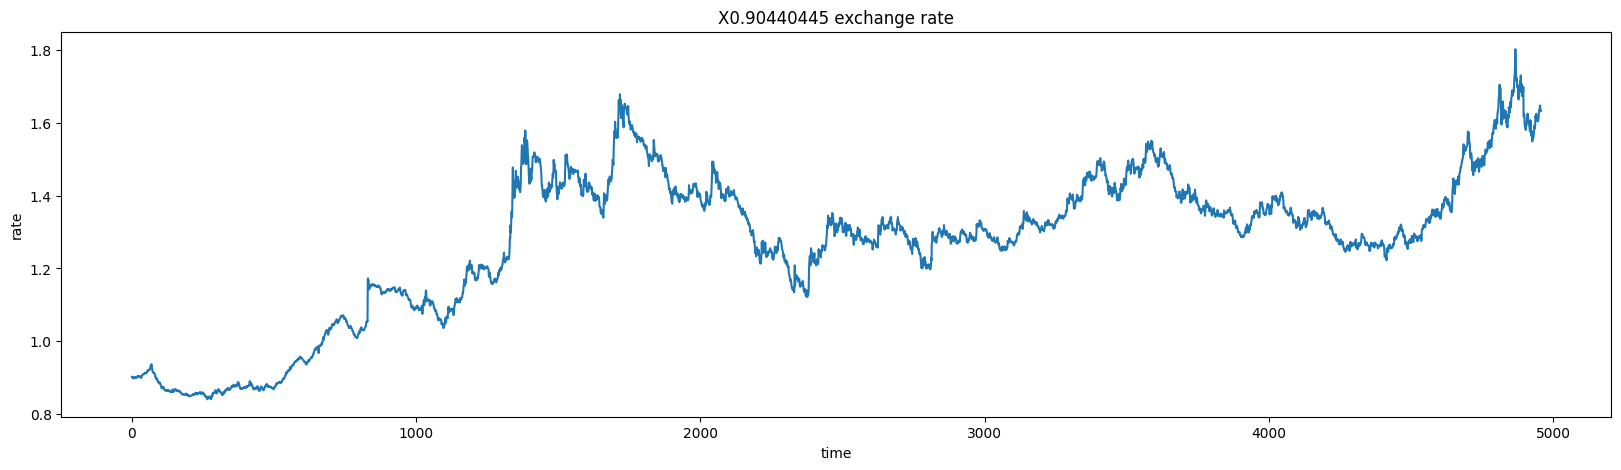

In [361]:
plot_assignation(ts, 'X0.90440445 exchange rate', 'time', 'rate')

In [363]:
nottrend = []
s = 296
notseason = []

# выборка без тренда
for i in range(1, len(ts)):
    nottrend.append(ts[i] - ts[i - 1])

# выборка без сезонности (кажется, у ряда нет сезонности)
for i in range(s, len(ts)):
    notseason.append(ts[i] - ts[i - s])

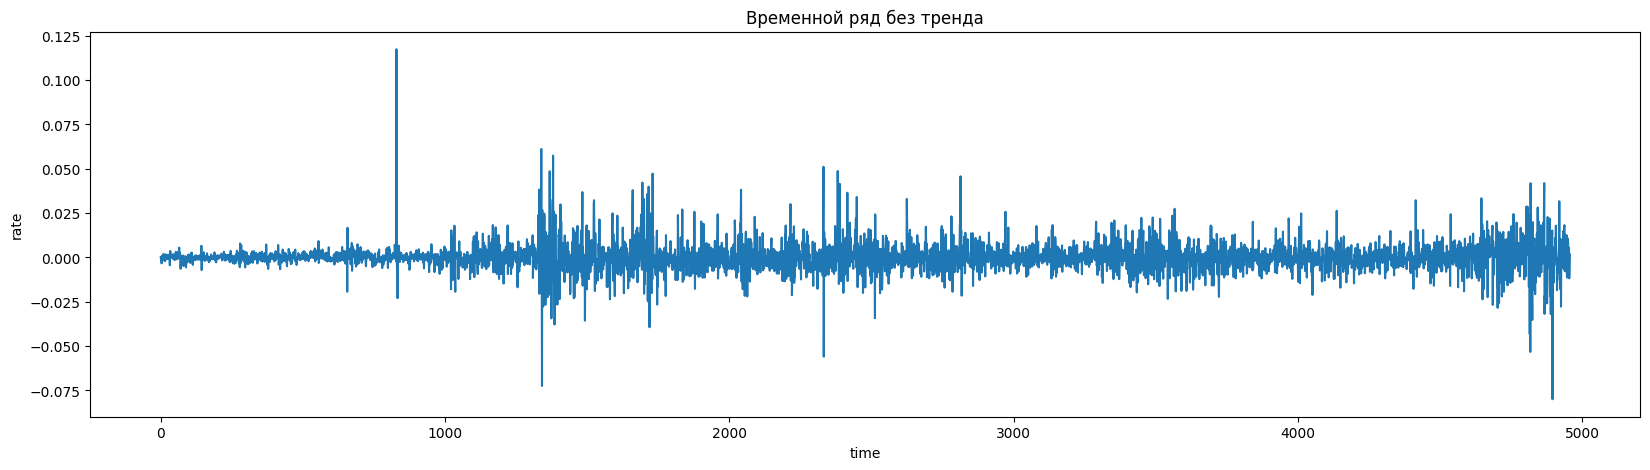

In [364]:
plot_assignation(nottrend, 'Временной ряд без тренда', 'time', 'rate')

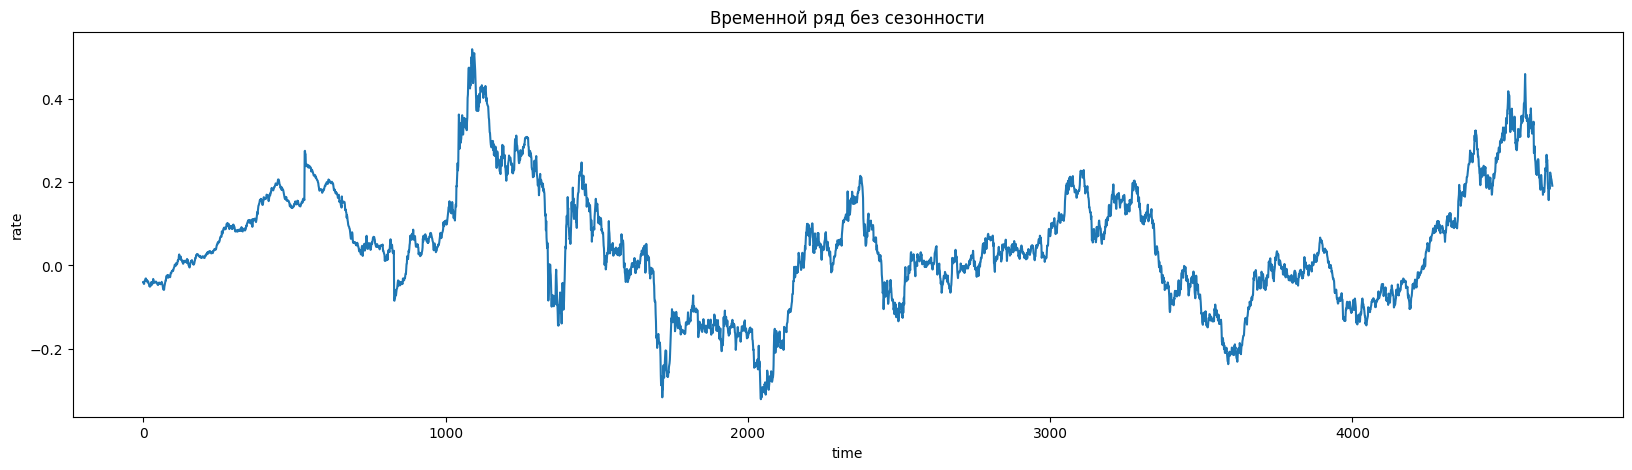

In [365]:
plot_assignation(notseason, 'Временной ряд без сезонности', 'time', 'rate')

### Тесты Дики-Фуллера

In [37]:
# временной ряд без тренда
dickey_fuller_test(nottrend, 'Без тренда')

Тест Дики-Фуллера ряда Без тренда:
Test Statistic                -1.392452e+01
p-value                        5.222467e-26
#Lags Used                     2.000000e+01
Number of Observations Used    4.936000e+03
Critical Value (1%)           -3.431676e+00
Critical Value (5%)           -2.862126e+00
Critical Value (10%)          -2.567082e+00
dtype: float64

Значение p меньше 5.0%. Ряд стационарный.


In [38]:
# временной ряд без сезонности
dickey_fuller_test(notseason, 'Без сезонности')

Тест Дики-Фуллера ряда Без сезонности:
Test Statistic                   -3.148437
p-value                           0.023170
#Lags Used                       22.000000
Number of Observations Used    4639.000000
Critical Value (1%)              -3.431760
Critical Value (5%)              -2.862163
Critical Value (10%)             -2.567102
dtype: float64

Значение p меньше 5.0%. Ряд стационарный.


### Преобразование Бокса-Кокса

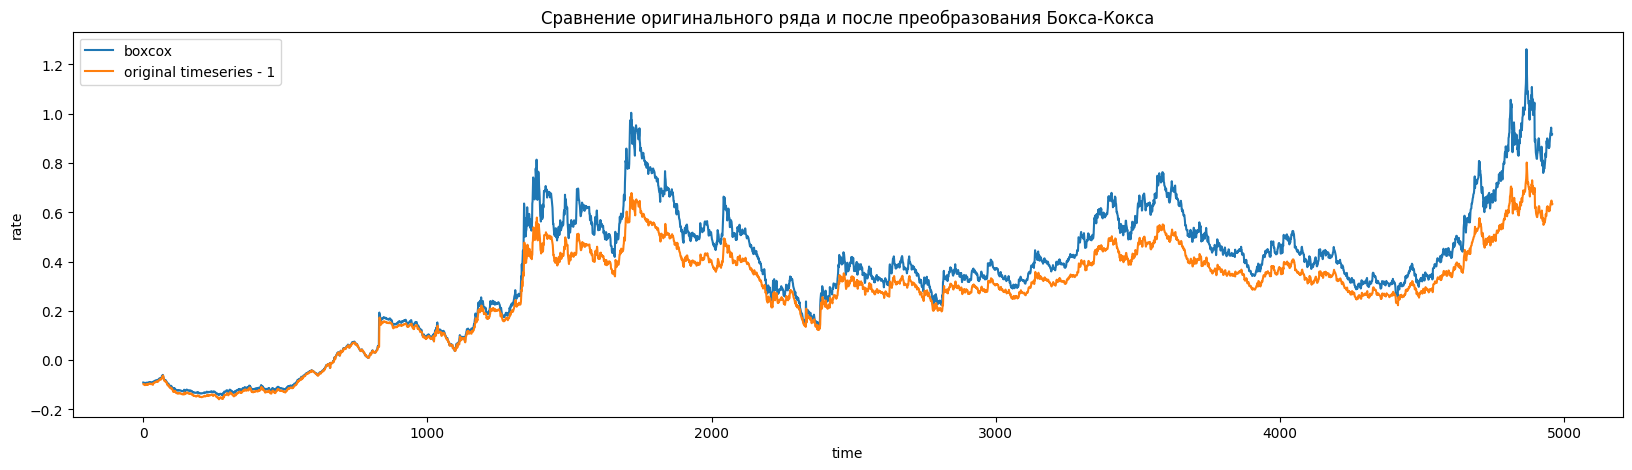

In [39]:
from scipy.stats import boxcox

# вызываем функцию преобразования, которая выдает преобразованные данные и
# лучший параметр лямбда, который обеспечивает близость к нормальному
# распределению
transformed_data, best_lambda = boxcox(ts)

# а теперь посмотрим на преобразованные данные
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(transformed_data)
plt.plot(ts - 1)
plt.title('Сравнение оригинального ряда и после преобразования Бокса-Кокса')
plt.xlabel('time')
plt.ylabel('rate')
plt.legend(['boxcox', 'original timeseries - 1'])

In [428]:
dickey_fuller_test(np.diff(transformed_data), 'После Бокса-Кокса')

Тест Дики-Фуллера ряда После Бокса-Кокса:
Test Statistic                -1.325643e+01
p-value                        8.569416e-25
#Lags Used                     2.100000e+01
Number of Observations Used    4.935000e+03
Critical Value (1%)           -3.431676e+00
Critical Value (5%)           -2.862126e+00
Critical Value (10%)          -2.567082e+00
dtype: float64

Значение p меньше 5.0%. Ряд стационарный.


### Автокорреляция и частичная автокорреляция

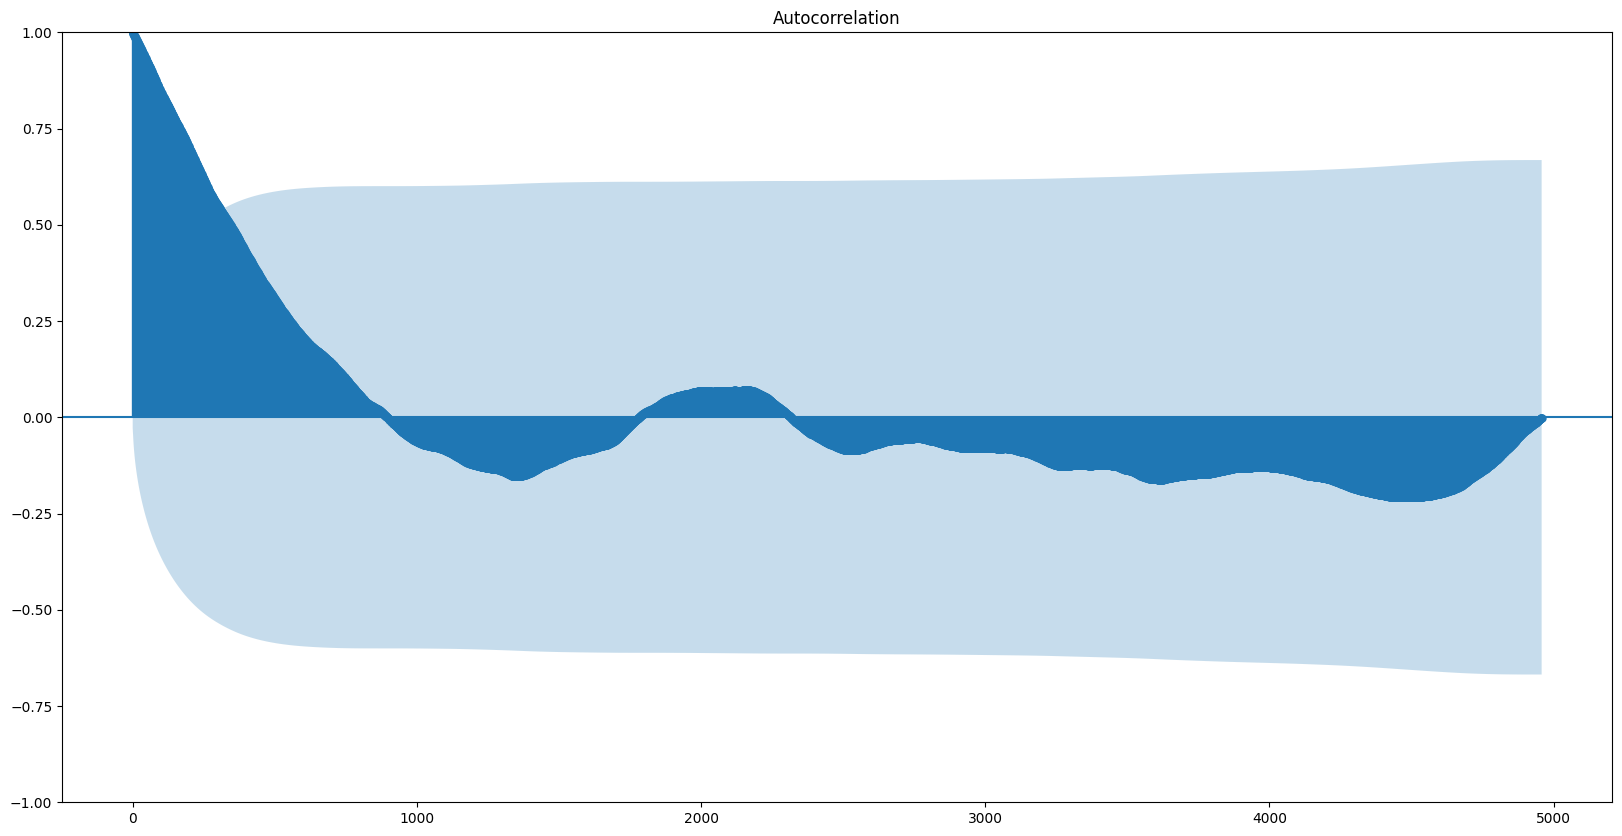

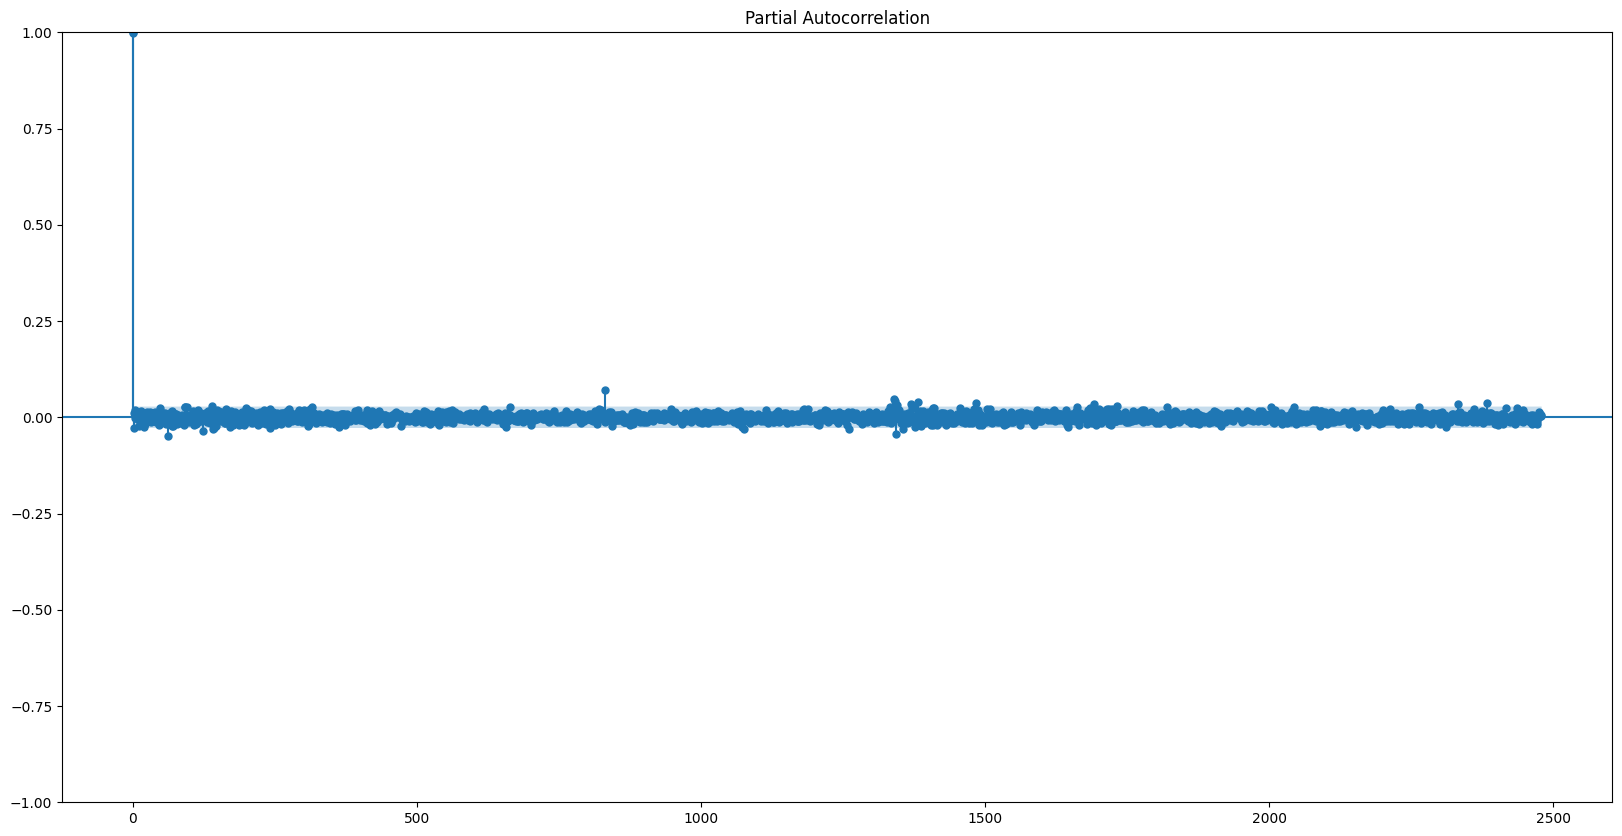

In [ ]:
import statsmodels.tsa.api as smt

sc_plot = smt.graphics.plot_acf(ts, lags=4957)
pac_plot = smt.graphics.plot_pacf(ts, lags=2479)

plt.show()

### Разбиение датасета на обучающую, валидационную и тестовую выборки

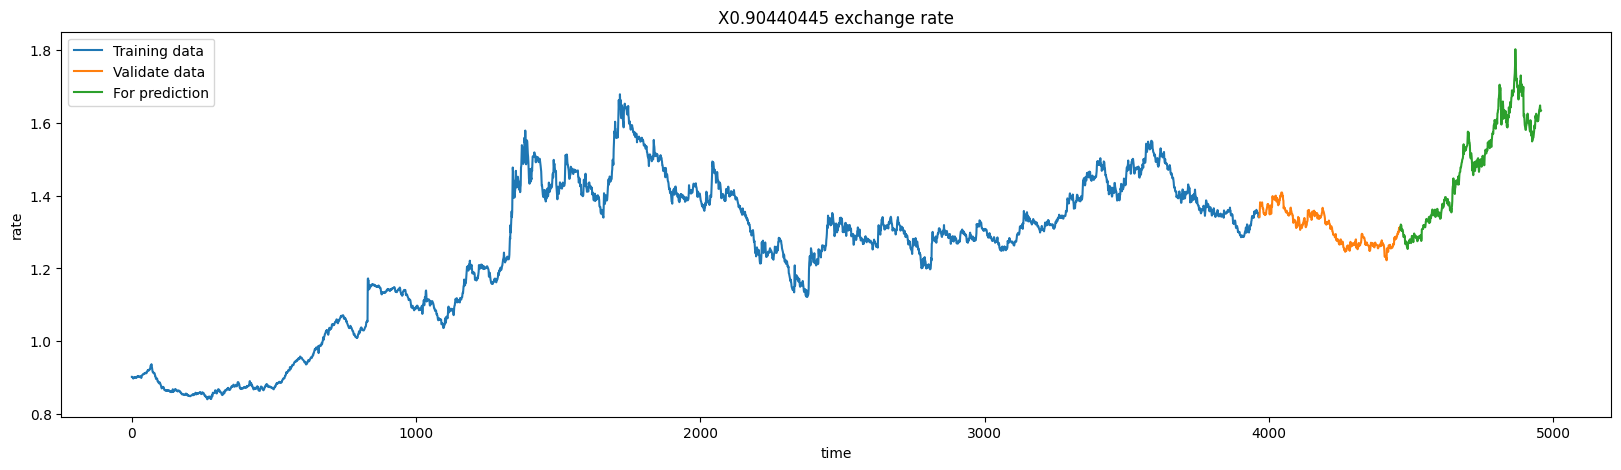

In [411]:

series = ts
ln = len(series)
train_cutoff = int(round(ln * 0.8, 0))
validate_cutoff = int(round(ln * 0.9, 0))

# Делим данные на обучающую, валидационную и тестовую выборки
train_ts = series[series.index < train_cutoff]
validate_ts = series[(series.index >= train_cutoff) &
                     (series.index < validate_cutoff)]
forecast_ts = series[series.index >= validate_cutoff]

# Выводим график данных
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.plot(train_ts.index, train_ts, label='Training data')
plt.plot(validate_ts.index, validate_ts, label='Validate data')
plt.plot(forecast_ts.index, forecast_ts, label='For prediction')
plt.legend()
plt.title('X0.90440445 exchange rate')
plt.ylabel('rate')
plt.xlabel('time')
plt.show()

In [412]:
# Импортируем модель авторегрессии
from statsmodels.tsa.ar_model import ar_select_order

# Сознательно обучаем модель авторегрессии на всём датасете (как в лекции)
sel = ar_select_order(ts, 100, old_names=False)
res = sel.model.fit()

# Выводим результаты обучения модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:            X0.90440445   No. Observations:                 4958
Model:                     AutoReg(2)   Log Likelihood               16868.850
Method:               Conditional MLE   S.D. of innovations              0.008
Date:                Fri, 22 Mar 2024   AIC                         -33729.701
Time:                        22:38:09   BIC                         -33703.667
Sample:                             2   HQIC                        -33720.572
                                 4958                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0012      0.001      1.699      0.089      -0.000       0.003
X0.90440445.L1     1.0493      0.014     73.961      0.000       1.021       1.077
X0.90440445.L2    -0.0502      0.014

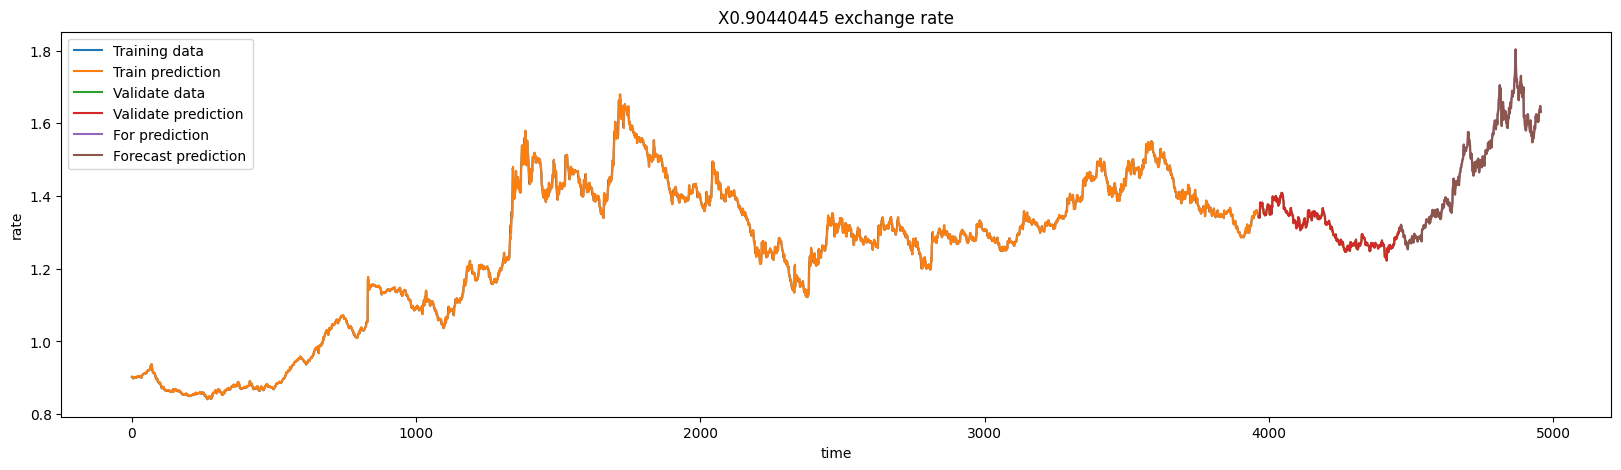

In [413]:
# Делаем прогноз на обучающей, валидационной и тестовой выборках
pred = res.predict(start=0, end=train_cutoff - 1, dynamic=False)
v_pred = res.predict(
    start=train_cutoff,
    end=validate_cutoff - 1,
    dynamic=False)
f_pred = res.predict(start=validate_cutoff, end=len(series) - 1, dynamic=False)

# Выводим график исходных данных и прогноза
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

plt.plot(train_ts.index, train_ts, label='Training data')
plt.plot(train_ts.index, pred, label='Train prediction')

plt.plot(validate_ts.index, validate_ts, label='Validate data')
plt.plot(validate_ts.index, v_pred, label='Validate prediction ')

plt.plot(forecast_ts.index, forecast_ts, label='For prediction')
plt.plot(forecast_ts.index, f_pred, label='Forecast prediction')

plt.legend()
plt.title('X0.90440445 exchange rate')
plt.ylabel('rate')
plt.xlabel('time')
plt.show()

### Метрики точности прогноза

In [414]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_ts, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_ts, f_pred))
print("MAE:", mean_absolute_error(forecast_ts, f_pred))
print("R2: ", r2_score(forecast_ts, f_pred))

RMSE: 0.011342962770522885
MAPE: 0.005182564709799381
MAE: 0.007862005263378288
R2:  0.9933314918082273


### P.S.

In [415]:
sel.ar_lags

[1, 2]

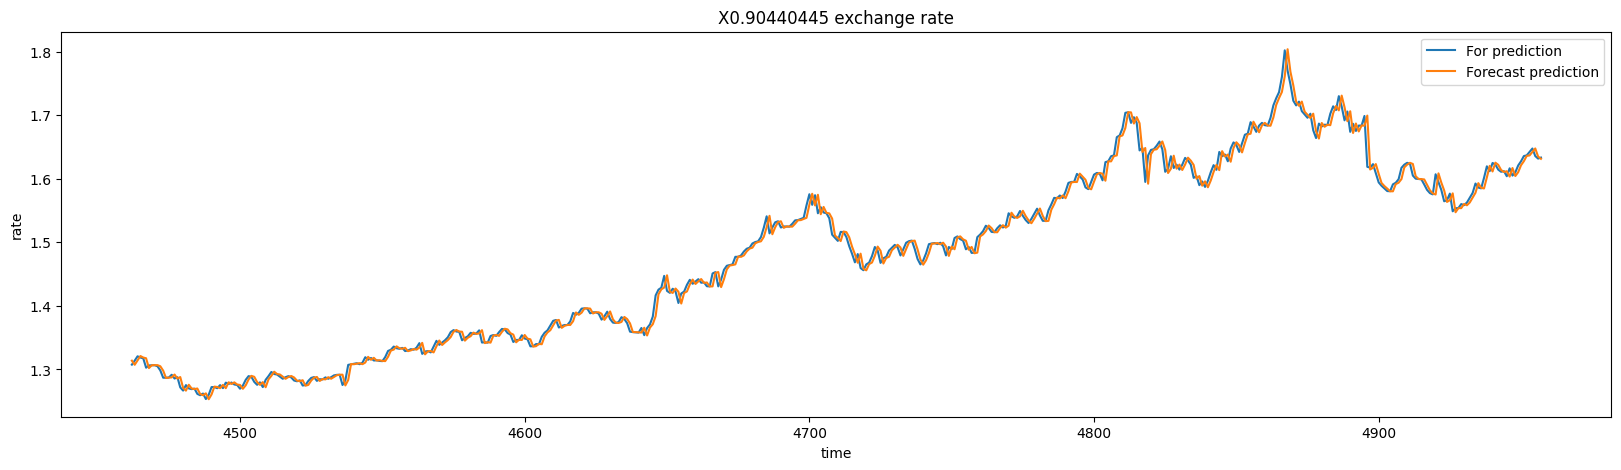

In [416]:
# Выводим график исходных прогноза
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

plt.plot(forecast_ts.index, forecast_ts, label='For prediction')
plt.plot(forecast_ts.index, f_pred, label='Forecast prediction')

plt.legend()
plt.title('X0.90440445 exchange rate')
plt.ylabel('rate')
plt.xlabel('time')
plt.show()

In [418]:
# Видно, что авторегрессионная модель с лагами [1, 2] никак не описывает наши данные
# А просто повторяет предыдущее значение ряда

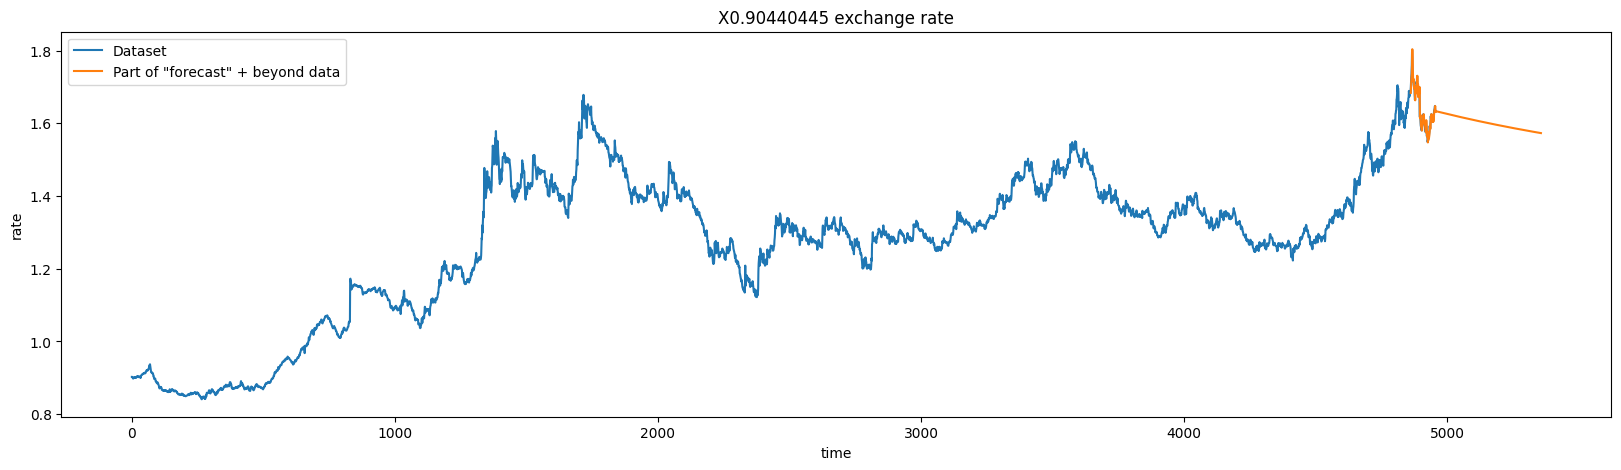

In [426]:
# Если предсказывать за рамками датасета, то имеем:

f_pred = res.predict(
    start=validate_cutoff + 400,
    end=len(series) - 1 + 400,
    dynamic=False)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

plt.plot(ts.index, ts, label='Dataset')
plt.plot(forecast_ts.index + 400, f_pred,
         label='Part of "forecast" + beyond data')

plt.legend()
plt.title('X0.90440445 exchange rate')
plt.ylabel('rate')
plt.xlabel('time')
plt.show()